## **CS235 Project Part 3**


### Kelsey Musolf


#### SID: 862191249

*****************************************************
## **Unsupervised Techniques**

In this third part we are going to focus on unsupervised techniques.

For all clustering results reported in this phase, when referring to “performance” you should run
the clustering algorithm 10 times with different random initializations and report the average +/-
standard deviation of the Silhouette coefficient. You may use the existing Silhouette
implementation of Sklearn. When plotting the performance, you should always produce
error-bars. Whenever your figure contains more than one line/graph (e.g., performance of two
classifiers), you should always make sure those are easily distinguishable (use different colors
and markers) and make sure you include a legend


**Clustering using raw data vs. learned representations**

In this question, we are going to compare the clustering performance of k-means and Spectral
Clustering as applied to 

(a) the raw data  
(b) learned representations. 

More specifically, borrowing from Part 2, we are going to use a randomly sampled 80% of dataset ‘A’ as our
training/test/validation set in order to train the same 2-layer CNN from that question. This CNN
presumably has learned effective representations of the data that are more concise than the raw
features. We are, then, going to cluster the remaining 20% of dataset ‘A’, where raw data is
essentially a long vector of all the pixels of a given image and the learned representation is the
vector that is given as an input to the fully-connected layers by the “feature/representation
learning” part of the network.


What to plot: For number of clusters K= 1 - 5, plot the clustering performance of k-means and
Spectral Clustering when applied on the raw and the learned representations for the remaining
20% of dataset ‘A’.

*****************************************************

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Subset, random_split

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


from sklearn.metrics import f1_score

ImportError: dlopen(/Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/_C.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libtorch_cpu.dylib
  Referenced from: <CAAE989C-40C8-3FB8-9884-428C5531E9E3> /Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_python.dylib
  Reason: tried: '/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/_build_env/lib/libtorch_cpu.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/_build_env/lib/libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/lib/../../../../libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/../../../libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/lib/python3.10/site-packages/torch/../../../libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/bin/../lib/libtorch_cpu.dylib' (no such file), '/Users/kelseymusolf/anaconda3/bin/../lib/libtorch_cpu.dylib' (no such file), '/usr/local/lib/libtorch_cpu.dylib' (no such file), '/usr/lib/libtorch_cpu.dylib' (no such file, not in dyld cache)

First lets start with splitting of the dataset - same as in part 2 of the project. 

For part 3 of the project, using the MINST dataset again but this time only using split A, digits 0-4. I will now split into 80% and 20%

In [58]:
#transformation
transform = transforms.Compose([transforms.ToTensor()])

#get the MNIST  dataset
mnist_full = datasets.MNIST(root='./data', train=True, transform=transform, download=True)



#keep only 0-4
subset_A_indices = [i for i, (_, label) in enumerate(mnist_full) if label < 5]
subset_A = Subset(mnist_full, subset_A_indices)

# split into 80% train and 20% test
train_size = int(0.8 * len(subset_A))
test_size = len(subset_A) - train_size

train_A, test_A = random_split(subset_A, [train_size, test_size])

#output to check...
print(f"Train size: {len(train_A)}")
print(f"Test size: {len(test_A)}")


Train size: 24476
Test size: 6120


**CNN-2**

I will now use CNN-2 (repeat from part 2 of project) to train and test the data for labels before clustering.

First the class for CNN2: this uses 3 functions to do all the CNN layers on the data before clustering. 

In [59]:

#class for CNN2
class CNN2(nn.Module):

    #===========first function: required initilization for model. ==============
    
    def __init__(self):
        super(CNN2, self).__init__()
        #feature extractor
         #get patterns - out: 16×28×28 
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2) 
        #reduce the size - out: 16×14×14
        self.pool1 = nn.MaxPool2d(2, 2)                    
        #get most important features - out: 32×14×14
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2) 
        #reduce size - out: 32×7×7
        self.pool2 = nn.MaxPool2d(2, 2)                       

        #fully connected layers (classification head — not used for clustering)
        self.fc1 = nn.Linear(32 * 7 * 7, 100)
        # 5 classes (digits 0–4)
        self.fc2 = nn.Linear(100, 5)  

#================function 2: using ReLu==============

    def forward(self, x):
        #filters applied and relu to make non-linear, then downsample
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        self.feature_output = x.view(x.size(0), -1)  # Save features for extraction
        x = F.relu(self.fc1(self.feature_output))
        x = self.fc2(x)
        return x
    
#========function 3; using this for clustering!===================

    def extract_features(self, x):
        #only run the convolutional feature extractor
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        return x.view(x.size(0), -1)


This followng code is shuffling the data so the training model sees differnet orderings of the same data. 

I chose a batch size of 64, (so 64 images are loaded at a time) the internet says 64 is a common number.
It's good for faster computations because it takes in enough to not have to optimize too many times (like smaller batches) and is still small enough to be fast

In [60]:
#hyperparameter:
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_A, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_A, batch_size=batch_size, shuffle=False)

Training loop for dataset A set up w/ hyperarameters

In [61]:

#hyperparameters
num_epochs = 10
learning_rate = 0.001

#model, loss, optimizer
model = CNN2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Now the actual looping:

In [62]:
for epoch in range(num_epochs):

    #train model
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    #run on each image
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #track stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    #print epoch summary
    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch [1/10], Loss: 51.5649, Accuracy: 95.79%
Epoch [2/10], Loss: 11.4529, Accuracy: 99.12%
Epoch [3/10], Loss: 6.9648, Accuracy: 99.51%
Epoch [4/10], Loss: 4.9093, Accuracy: 99.63%
Epoch [5/10], Loss: 4.0159, Accuracy: 99.64%
Epoch [6/10], Loss: 2.6458, Accuracy: 99.79%
Epoch [7/10], Loss: 2.1784, Accuracy: 99.82%
Epoch [8/10], Loss: 2.0516, Accuracy: 99.82%
Epoch [9/10], Loss: 1.2112, Accuracy: 99.90%
Epoch [10/10], Loss: 1.5844, Accuracy: 99.86%


In [63]:
#saving model incase I need to use later (may delete if not...)

torch.save(model.state_dict(), "cnn2_model.pth")

## Clustering

Clustering now can begin on test_A:

**K-means Clustering**
- raw data
- CNN2 data

**Spectral**
- raw data
- CNN2 data

I will start with K-means clustering on the raw data

In [64]:
#training:
#put model in eval mode and move to CPU
device = torch.device("cpu")

#get all raw pixel vectors from test_A
raw_pixels = []

#flatten the pixels into 2D array
for image, _ in test_A:
    #flatten 1×28×28 → 784
    image = image.view(-1) 
    raw_pixels.append(image.numpy())

import numpy as np
raw_data = np.stack(raw_pixels) 
print("Raw data shape:", raw_data.shape)
#shape: num_samples, 784
#this is 20% of digits 0-4

Raw data shape: (6120, 784)


Now to use Kmeans clustering with silhouette score. 

I will repeat 10 times each with a loop and changing the value of k from 1 to 5 incrementally. 

In [65]:
k_values = range(1, 6)
raw_kmeans_mean_scores = []
raw_kmeans_std_scores = []

for k in k_values:
    scores = []
    if k == 1:
        raw_kmeans_mean_scores.append(0.0)
        raw_kmeans_std_scores.append(0.0)
        continue  # silhouette score is undefined for k=1

    for seed in range(10):
        #run k means with updated parameters, label and get score
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
        labels = kmeans.fit_predict(raw_data)
        score = silhouette_score(raw_data, labels)
        scores.append(score)

    raw_kmeans_mean_scores.append(np.mean(scores))
    raw_kmeans_std_scores.append(np.std(scores))

    #print out each score
    mean_k = np.mean(scores)
    std_k = np.std(scores)


    print(f"k = {k}, silhouette score = {mean_k:.4f} ± {std_k:.4f}")


#show resuts:
# plt.errorbar(k_values, raw_kmeans_mean_scores, yerr=raw_kmeans_std_scores, label="KMeans on Raw", fmt='-o')
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("Silhouette Score")
# plt.title("KMeans Clustering on Raw MNIST Pixels (digits 0–4)")
# plt.grid(True)
# plt.legend()
# plt.show()


k = 2, silhouette score = 0.1404 ± 0.0000
k = 3, silhouette score = 0.1058 ± 0.0001
k = 4, silhouette score = 0.0989 ± 0.0002
k = 5, silhouette score = 0.1119 ± 0.0001


Now for the CNN-2 trained data. Ill need to repeat the steps above with getting the model flattened and using the same loop again to calculate the different K values 

In [66]:
#evaluation mode
model.eval() 
model = model.to("cpu")

#array to store features selected from CNN2
cnn_features = []

with torch.no_grad():
    for image, _ in test_A:
        image = image.unsqueeze(0)  # shape: (1, 1, 28, 28)
        feature = model.extract_features(image)
        cnn_features.append(feature.squeeze().numpy())

cnn_data = np.stack(cnn_features)  # shape: (num_samples, 1568)
print("CNN feature data shape:", cnn_data.shape)

CNN feature data shape: (6120, 1568)


And the loop 10 times with the different k values 1-5

In [67]:
kmeans_mean_scores_cnn = []
kmeans_std_scores_cnn = []

for k in k_values:
    scores = []
    if k == 1:
        kmeans_mean_scores_cnn.append(0.0)
        kmeans_std_scores_cnn.append(0.0)
        continue

    for seed in range(10):
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
        labels = kmeans.fit_predict(cnn_data)
        score = silhouette_score(cnn_data, labels)
        scores.append(score)

    kmeans_mean_scores_cnn.append(np.mean(scores))
    kmeans_std_scores_cnn.append(np.std(scores))

    #print out each score
    mean_k = np.mean(scores)
    std_k = np.std(scores)


    print(f"k = {k}, silhouette score = {mean_k:.4f} ± {std_k:.4f}")


k = 2, silhouette score = 0.1327 ± 0.0000
k = 3, silhouette score = 0.1467 ± 0.0044
k = 4, silhouette score = 0.1769 ± 0.0000
k = 5, silhouette score = 0.1923 ± 0.0000


Now to plot both raw data and CNN data:

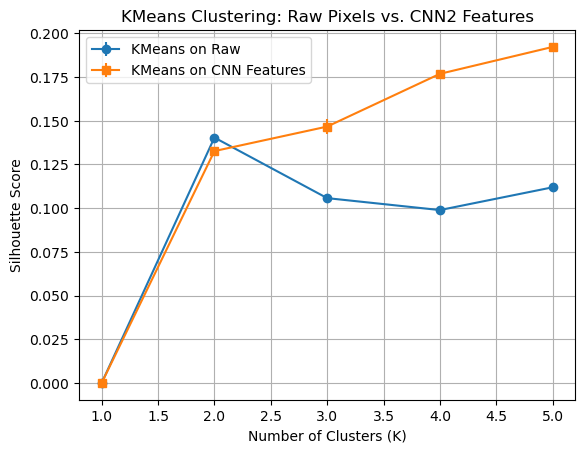

In [68]:

plt.errorbar(k_values, raw_kmeans_mean_scores, yerr=raw_kmeans_std_scores, label="KMeans on Raw", fmt='-o')
plt.errorbar(k_values, kmeans_mean_scores_cnn, yerr=kmeans_std_scores_cnn, label="KMeans on CNN Features", fmt='-s')

plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("KMeans Clustering: Raw Pixels vs. CNN2 Features")
plt.grid(True)
plt.legend()
plt.show()

-------------------------------------------------

**Spectral Clustering**

Now to perform the same two actions this time using spectral clustering. Spectral clustering uses a graph theory to group the points together instead of the k-means which is grouping based on distance to nearest centroid. 

Start on the raw data first:

In [69]:
from sklearn.cluster import SpectralClustering

mean_scores_spec_raw = []
std_scores_spec_raw = []

for k in k_values:
    scores = []
    if k == 1:
        mean_scores_spec_raw.append(0.0)
        std_scores_spec_raw.append(0.0)
        continue

    for seed in range(10):
        sc = SpectralClustering(n_clusters=k, random_state=seed, affinity='nearest_neighbors', n_neighbors=10, assign_labels='kmeans')
        labels = sc.fit_predict(raw_data)
        score = silhouette_score(raw_data, labels)
        scores.append(score)

    mean_scores_spec_raw.append(np.mean(scores))
    std_scores_spec_raw.append(np.std(scores))

    #print out each score
    mean_k = np.mean(scores)
    std_k = np.std(scores)

    print(f"k = {k}, silhouette score = {mean_k:.4f} ± {std_k:.4f}")

k = 2, silhouette score = 0.1380 ± 0.0000
k = 3, silhouette score = 0.0933 ± 0.0000
k = 4, silhouette score = 0.0972 ± 0.0000
k = 5, silhouette score = 0.0692 ± 0.0000


repeat again on CNN-2 features

In [70]:
mean_scores_spec_cnn = []
std_scores_spec_cnn = []

for k in k_values:
    scores = []
    if k == 1:
        mean_scores_spec_cnn.append(0.0)
        std_scores_spec_cnn.append(0.0)
        continue

    for seed in range(10):
        sc = SpectralClustering(n_clusters=k, random_state=seed, affinity='nearest_neighbors', n_neighbors=10, assign_labels='kmeans')
        labels = sc.fit_predict(cnn_data)
        score = silhouette_score(cnn_data, labels)
        scores.append(score)

    mean_scores_spec_cnn.append(np.mean(scores))
    std_scores_spec_cnn.append(np.std(scores))

    #print out each score
    mean_k = np.mean(scores)
    std_k = np.std(scores)


    print(f"k = {k}, silhouette score = {mean_k:.4f} ± {std_k:.4f}")

k = 2, silhouette score = 0.1582 ± 0.0000
k = 3, silhouette score = 0.1531 ± 0.0000
k = 4, silhouette score = 0.1751 ± 0.0000
k = 5, silhouette score = 0.1663 ± 0.0000


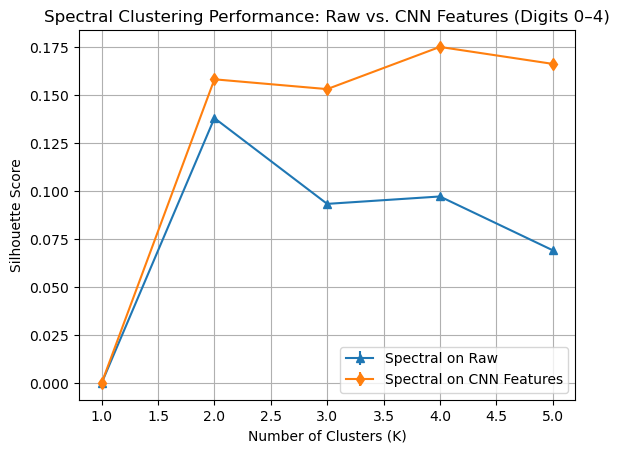

In [71]:
plt.errorbar(k_values, mean_scores_spec_raw, yerr=std_scores_spec_raw, label="Spectral on Raw", fmt='-^')
plt.errorbar(k_values, mean_scores_spec_cnn, yerr=std_scores_spec_cnn, label="Spectral on CNN Features", fmt='-d')

plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Spectral Clustering Performance: Raw vs. CNN Features (Digits 0–4)")
plt.grid(True)
plt.legend()
plt.show()

----------------------------------------------
### Final graph
And now to finally plot all 4 bars. 

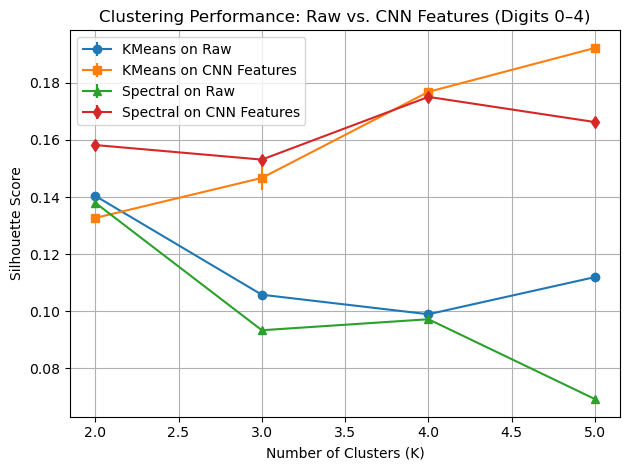

In [74]:
#plot from index 1 to skip k = 1
plt.errorbar(k_values[1:], raw_kmeans_mean_scores[1:], yerr=raw_kmeans_std_scores[1:], label="KMeans on Raw", fmt='-o')
plt.errorbar(k_values[1:], kmeans_mean_scores_cnn[1:], yerr=kmeans_std_scores_cnn[1:], label="KMeans on CNN Features", fmt='-s')
plt.errorbar(k_values[1:], mean_scores_spec_raw[1:], yerr=std_scores_spec_raw[1:], label="Spectral on Raw", fmt='-^')
plt.errorbar(k_values[1:], mean_scores_spec_cnn[1:], yerr=std_scores_spec_cnn[1:], label="Spectral on CNN Features", fmt='-d')

plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Clustering Performance: Raw vs. CNN Features (Digits 0–4)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

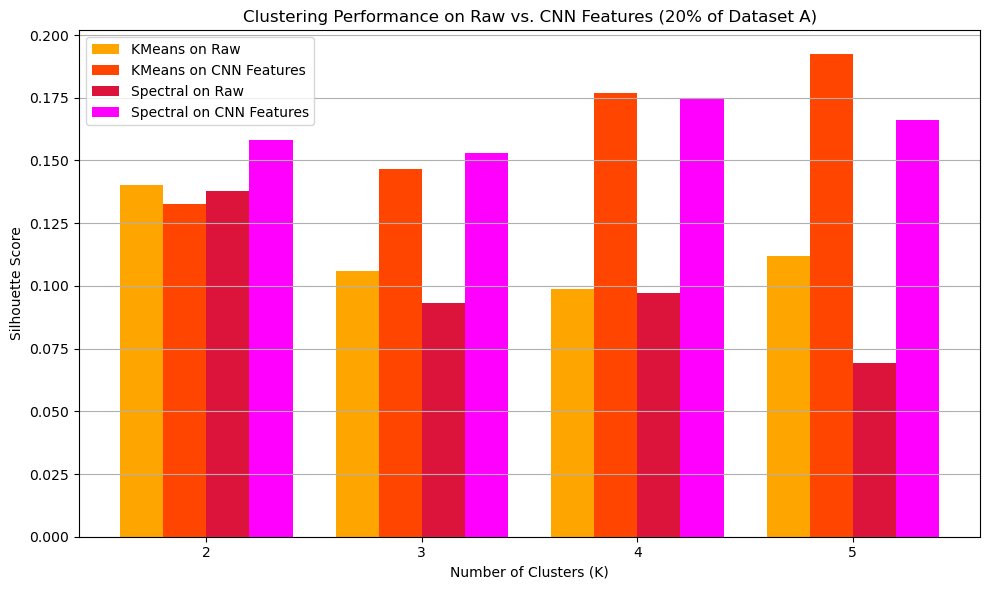

In [76]:
#cluster values (skip k = 1)
k_values = np.array([2, 3, 4, 5])
x = np.arange(len(k_values))  # now x has length 4
bar_width = 0.2

#cut off k=1 
raw_kmeans = raw_kmeans_mean_scores[1:]
kmeans_cnn = kmeans_mean_scores_cnn[1:]
spec_raw = mean_scores_spec_raw[1:]
spec_cnn = mean_scores_spec_cnn[1:]

#plot
plt.figure(figsize=(10, 6))

plt.bar(x - 1.5 * bar_width, raw_kmeans, width=bar_width, label='KMeans on Raw', color='orange')
plt.bar(x - 0.5 * bar_width, kmeans_cnn, width=bar_width, label='KMeans on CNN Features', color='orangered')
plt.bar(x + 0.5 * bar_width, spec_raw, width=bar_width, label='Spectral on Raw', color='crimson')
plt.bar(x + 1.5 * bar_width, spec_cnn, width=bar_width, label='Spectral on CNN Features', color='magenta')

plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Clustering Performance on Raw vs. CNN Features (20% of Dataset A)")
plt.xticks(ticks=x, labels=k_values)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


-----------------------------------------------
## Results

**Scores**

Silhouette scores are around 1 when they are really good, and closer to 0 when not. Why are my scores around .2 then? Given the task of this project, the data set is handwritten digits this means that the silhouette scores may not be great because of the real world application of messy handwriting.  

**Error Bars**

As for error bars... my error bars are so small they cannot be seen. I believe this to be because of the size of the data set (not enough for large outliers) and also because of the size of k. Because the number of digits match closely with the number of clusters, large errors are not expected. I also happened to use fixed seeds with kmeans and spectral clustering. This means there is minimal variation in the silhouette scores.

**k=1**

When k = 1, the value is always 0. This is because it is a trivial test where all the data is being clustered into one group, so no work needs to be done. It is simply the given data as is. 